In [1]:
import os
import dill as pickle
import ztffields
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor, as_completed
from astropy.io import fits, ascii

try:
    from Tile import Tile
    from utils import get_data_path
except ModuleNotFoundError:
    from Extracting.Tile import Tile
    from Extracting.utils import get_data_path

In [2]:
# Load the field geometries
fields = ztffields.Fields()  # TODO: Some filter on fields
field_info, field_polygons = fields.get_field_vertices([1557, 1558], level='quadrant', steps=2)

In [3]:
data_path = get_data_path()
quadrant = field_polygons[0][0]

# Get the center of the quadrant
ra_center, dec_center = np.mean(quadrant[:, 0]), np.mean(quadrant[:, 1])

# Make a tile, run extraction, and store the catalogs
tile = Tile(
    ra_center,
    dec_center,
    bands=['i'],
    data_dir=os.path.join(data_path, 'ztf_data'),
    parallel=False
)

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>89.80769428070157+AND+ra<90.69658318070158+AND+dec>12.446347031680897+AND+dec<13.335235931680899+AND+filtercode='zi'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000512_zi_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [4]:
tile.prefecth_catalogs() # 3615

Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


Calculating PSF magnitudes...
Fitting PSF model using 572 stars...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


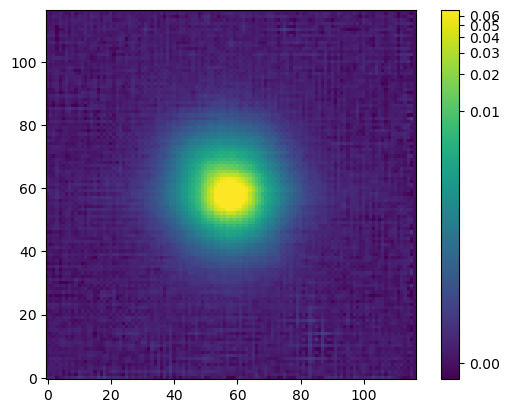

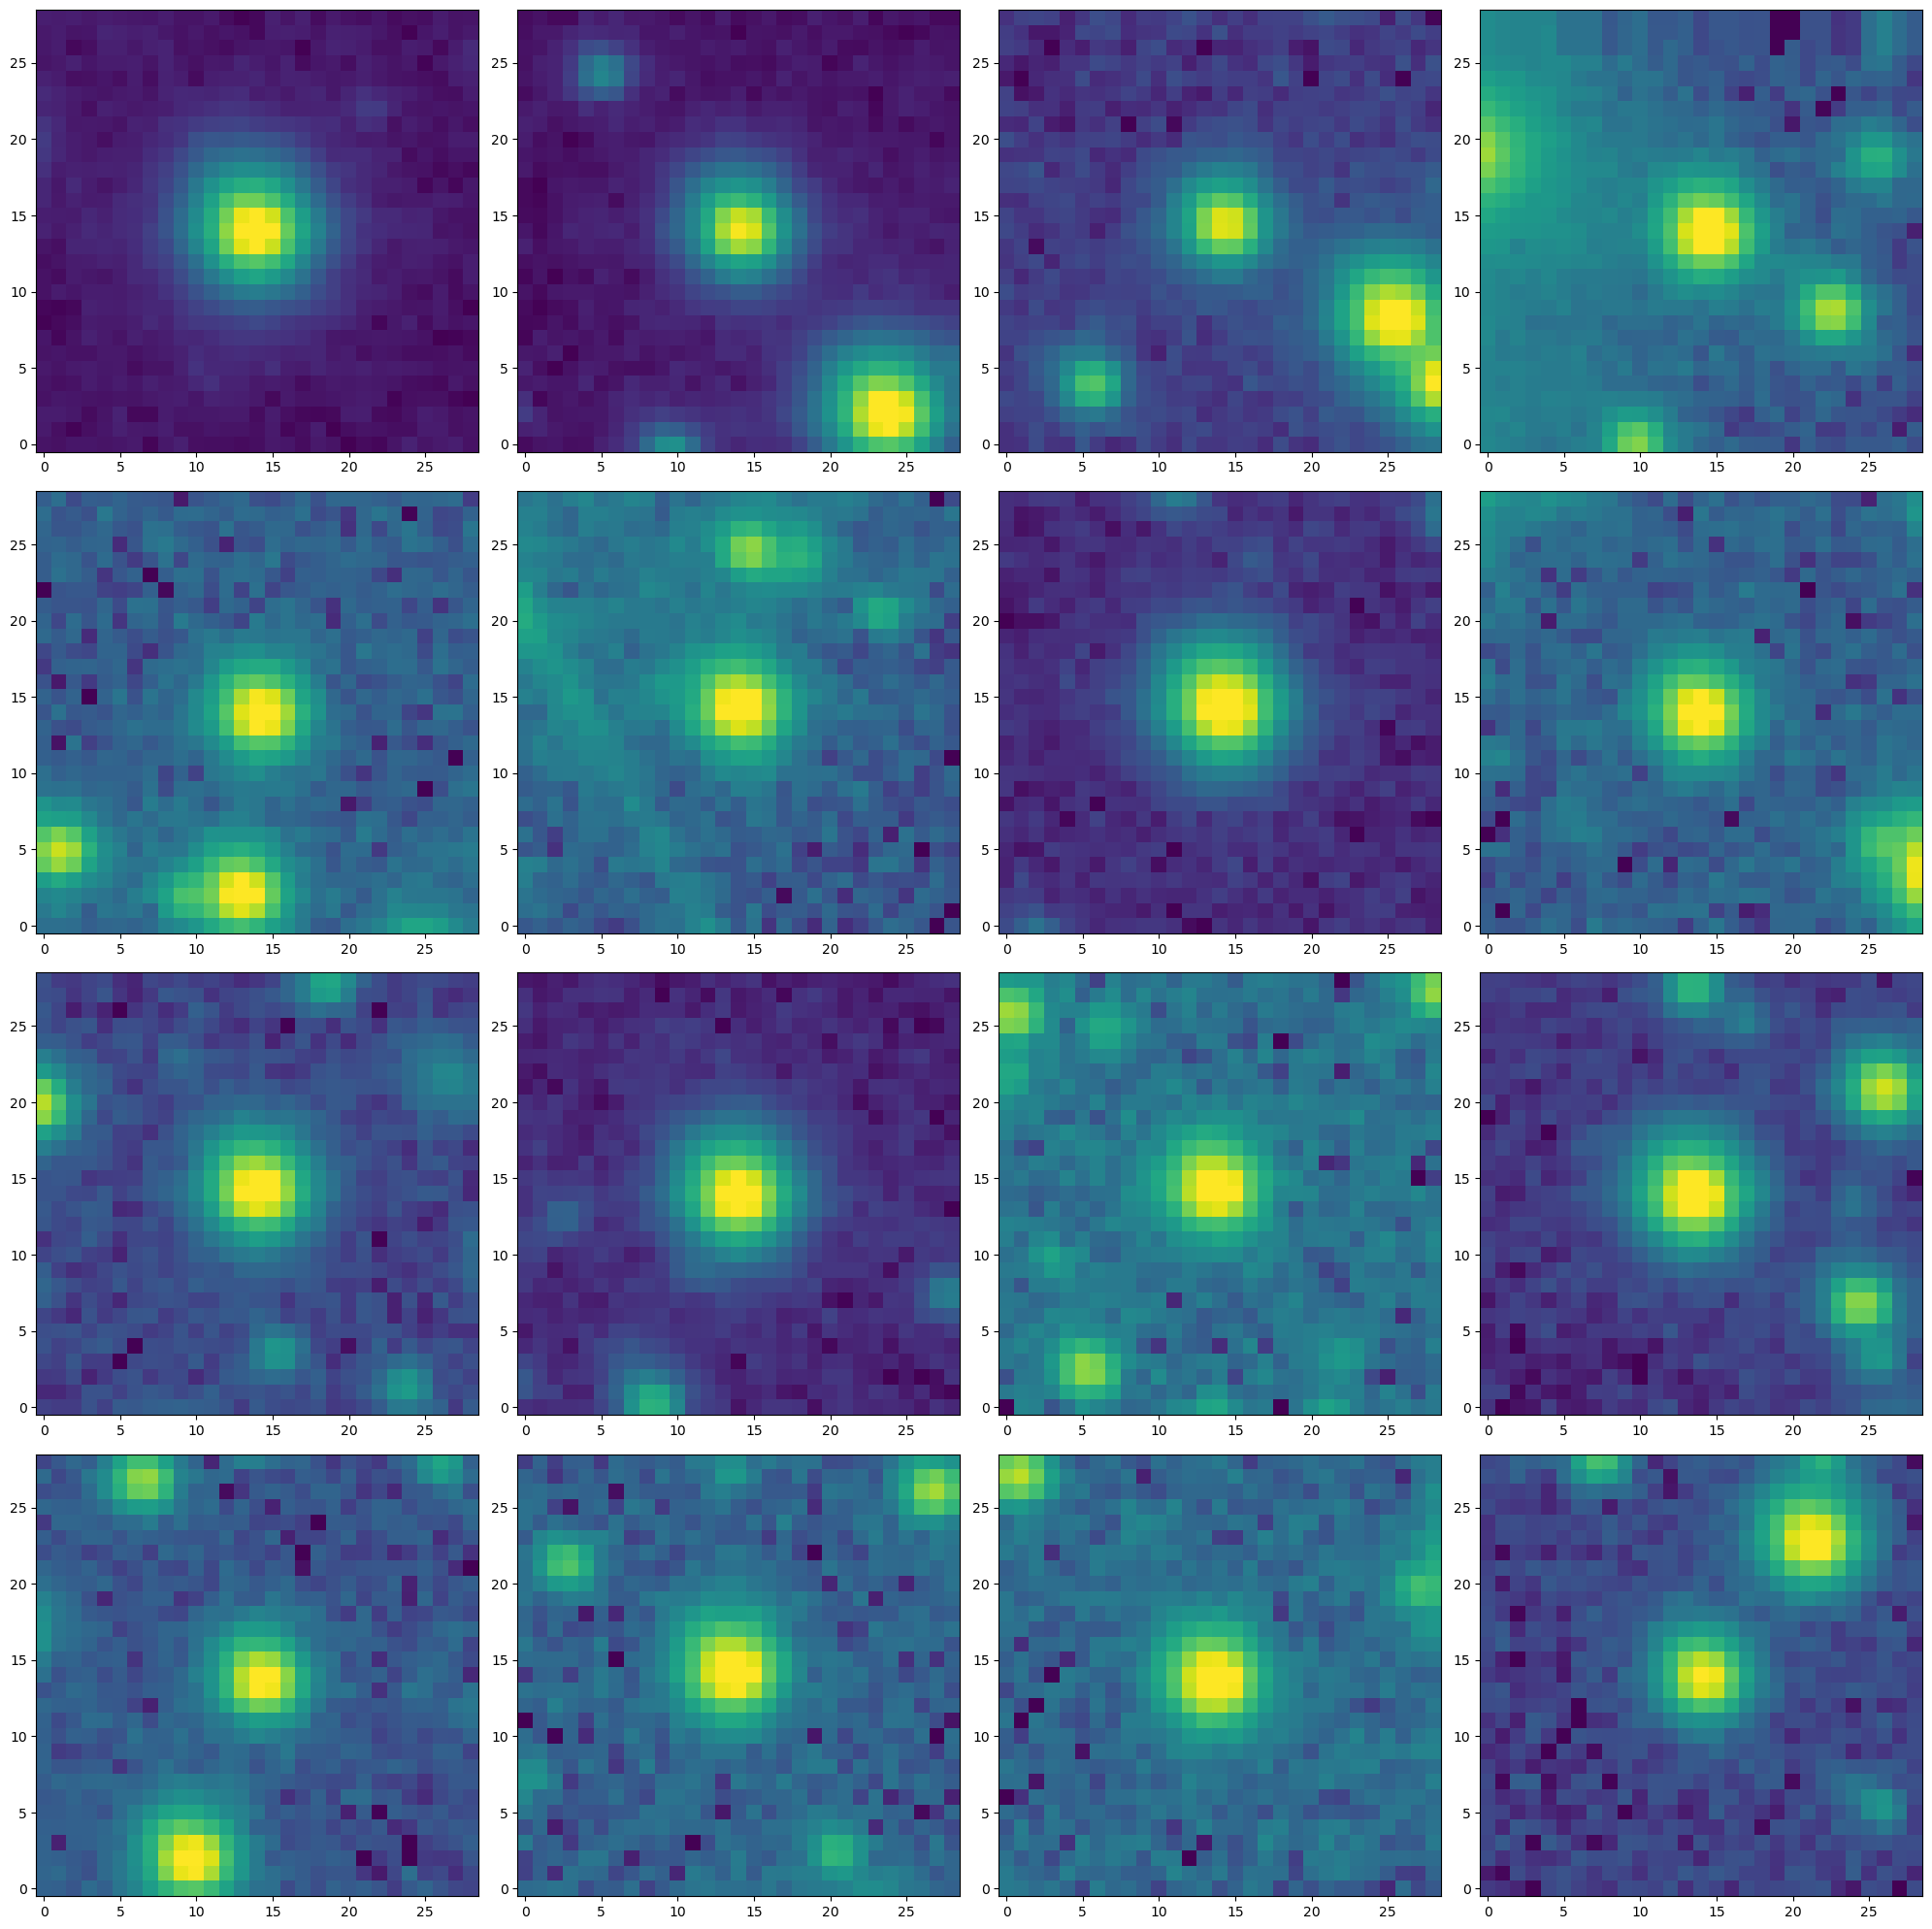

In [5]:
from astropy.visualization import simple_norm
norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].epsf.data, 'log', percent=99.0)
plt.imshow(tile.ztf_catalogs['i'].sextractors['i'].epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[i], 'log', percent=99.0)
    ax.imshow(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[i], norm=norm, origin='lower', cmap='viridis')
    width = tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[i].shape[1]
plt.tight_layout()
plt.show()

In [6]:
tile.store_catalogs('test_dir')

'test_dir/000512_12_1'

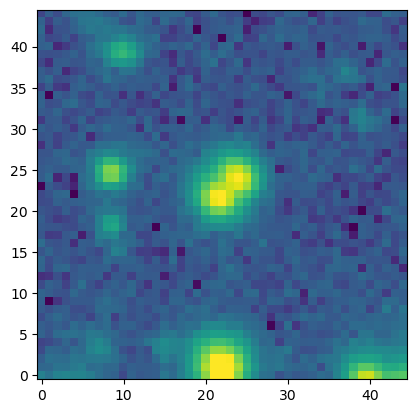

In [14]:
norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], 'log', percent=99.0)
plt.imshow(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], norm=norm, origin='lower', cmap='viridis')
plt.show()

In [47]:
cutout_half_width = tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13].shape[0] / 2
xs, ys = tile.ztf_catalogs['i'].sextractors['i'].ra_dec_to_pix(tile.ztf_catalogs['i'].sextractors['i']._point_source_coords.ra, tile.ztf_catalogs['i'].sextractors['i']._point_source_coords.dec)
xs_cutout, ys_cutout = xs - tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13].center[0] - 1, ys - tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13].center[1] - 1
xs_cutout, ys_cutout = xs_cutout[(np.abs(xs_cutout) < 22.5) & (np.abs(ys_cutout) < 22.5)], ys_cutout[(np.abs(xs_cutout) < 22.5) & (np.abs(ys_cutout) < 22.5)]
xs_cutout += cutout_half_width
ys_cutout += cutout_half_width

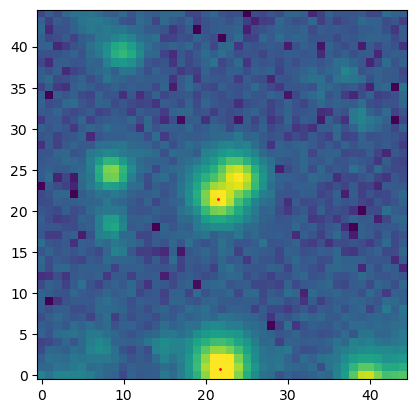

In [48]:
norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], 'log', percent=99.0)
plt.imshow(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], norm=norm, origin='lower', cmap='viridis')
plt.scatter(xs_cutout, ys_cutout, color='red', s=1)
plt.show()

[23.63386287 21.5       ] [23.71727857 21.5       ]


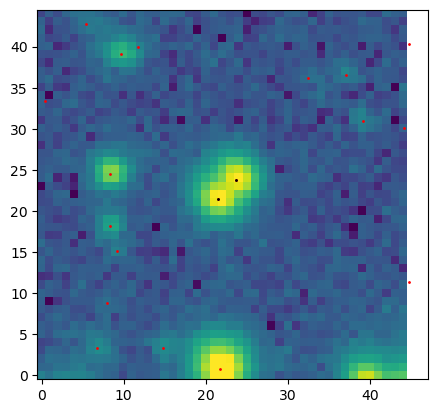

In [41]:
two_xs, two_ys = xs_cutout[(np.abs(xs_cutout-22.5) < 5) & (np.abs(ys_cutout-22.5) < 5)], ys_cutout[(np.abs(xs_cutout-22.5) < 5) & (np.abs(ys_cutout-22.5) < 5)]
norm = simple_norm(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], 'log', percent=99.0)
plt.imshow(tile.ztf_catalogs['i'].sextractors['i'].stars.all_good_stars[13], norm=norm, origin='lower', cmap='viridis')
plt.scatter(xs_cutout, ys_cutout, color='red', s=1)
plt.scatter(two_xs, two_ys, color='k', s=1)
print(two_xs, two_ys)
plt.show()

In [45]:
min_dists = []
for x, y in zip(two_xs, two_ys):
    dists = np.sqrt((two_xs - x)*(two_xs - x) + (two_ys - y)*(two_ys - y))
    min_dists.append(np.min(dists[dists != 0]))
min_dists = np.array(min_dists)
min_dists

array([3.07728696, 3.07728696])

In [22]:
test_ass = ascii.read('/Users/adamboesky/Research/long_transients/Data/test_dir/field_results/000512_i.ecsv')

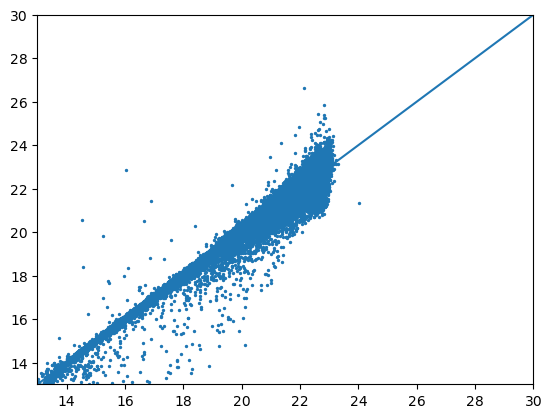

In [23]:
plt.scatter(test_ass['PSTARR_iPSFMag'], test_ass['PSTARR_iKronMag'], s=2)
plt.xlim((13, 30))
plt.ylim((13, 30))
plt.axline((15, 15), slope=1)

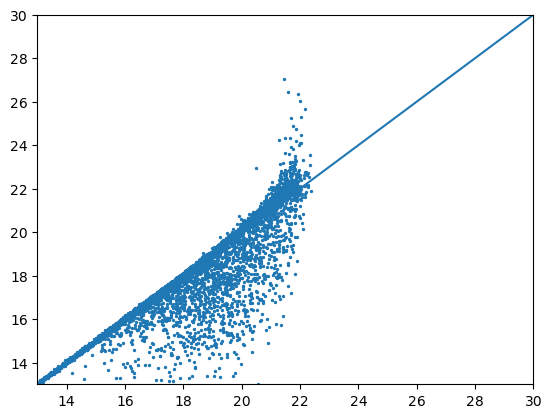

In [24]:
mask = (test_ass['ZTF_a'] / test_ass['ZTF_b']) < 1.05
plt.scatter(test_ass['ZTF_iPSFMag'][mask], test_ass['ZTF_iKronMag'][mask], s=2)
plt.xlim((13, 30))
plt.ylim((13, 30))
plt.axline((15, 15), slope=1)

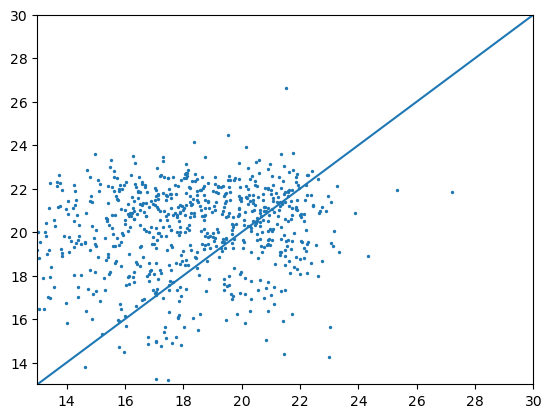

In [27]:
plt.scatter(test_ass['ZTF_iKronMag'], test_ass['PSTARR_iKronMag'], s=2)
plt.xlim((13, 30))
plt.ylim((13, 30))
plt.axline((15, 15), slope=1)

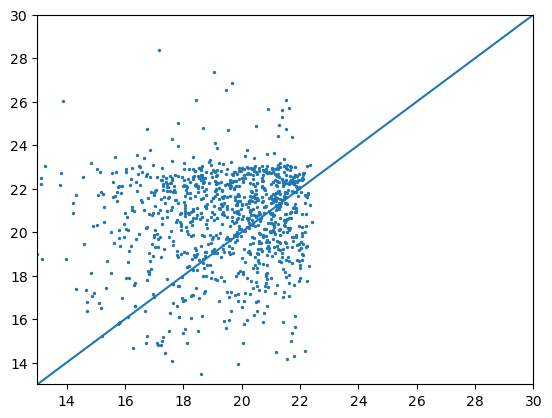

In [9]:
plt.scatter(test_ass['ZTF_iPSFMag'], test_ass['PSTARR_iPSFMag'], s=2)
plt.xlim((13, 30))
plt.ylim((13, 30))
plt.axline((15, 15), slope=1)

In [10]:
from astropy.table import Table
from astropy.nddata import NDData
from Extracting.utils import img_ab_mag_to_flux, img_flux_to_ab_mag
from photutils.psf import IntegratedGaussianPRF, PSFPhotometry, EPSFBuilder, EPSFFitter, extract_stars

In [12]:
self = tile.ztf_catalogs['i'].sextractors['i']

In [13]:
self.get_sources()
coords = self.get_sources_ra_dec()

# Add the magnitudes to the table
data_table = Table(self.sources)
kron_mags, kron_magerrs, circle_flag = self.get_kron_mags()
data_table[f'{self.band}KronMag'] = kron_mags
data_table[f'{self.band}KronMagErr'] = kron_magerrs
data_table[f'{self.band}KronCircleFlag'] = circle_flag

# Convert kron mags to fluxes
init_fluxes = img_ab_mag_to_flux(kron_mags, self.zero_pt_mag)
init_fluxes[kron_mags == -999.0] = 0.0

# Get the initial parameters for the PSF model
init_params = self.sources[['x', 'y']]
init_params['flux_init'] = init_fluxes

Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


In [16]:
# Fit the PSF model on a sample of just stars
print(f'Fitting PSF model using {len(self._point_source_coords)} stars...')
data_for_fit = NDData(data=self.image_sub, wcs=self.wcs)
self.stars = extract_stars(data_for_fit, Table([self._point_source_coords], names=['skycoord']), size=29)
fitter = EPSFFitter(fit_boxsize=int(self.r_fwhm * 2 + 1))
epsf_builder = EPSFBuilder(fitter=fitter)
self.epsf, _ = epsf_builder(self.stars)

# Perform the PSF photometry with the fitted model
self.psfphot = PSFPhotometry(self.epsf, fit_shape=(5, 5))
phot = self.psfphot(self.image_sub, error=self.bkg.rms(), init_params=init_params)

# Convert to magnitudes
mag, magerr = img_flux_to_ab_mag(phot['flux_fit'], self.zero_pt_mag, fluxerr=phot['flux_err'])

Fitting PSF model using 564 stars...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


In [23]:
29 / self.r_fwhm, np.ceil(self.r_fwhm * 14 // 2 * 2 + 1).astype(int)

(13.875598086124404, 29)

In [21]:
test = 2
test = int(np.ceil(test) // 2 * 2 + 1)
test

3

In [24]:
self.r_fwhm

2.09

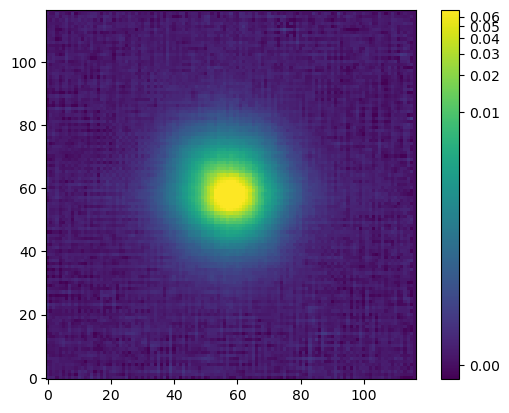

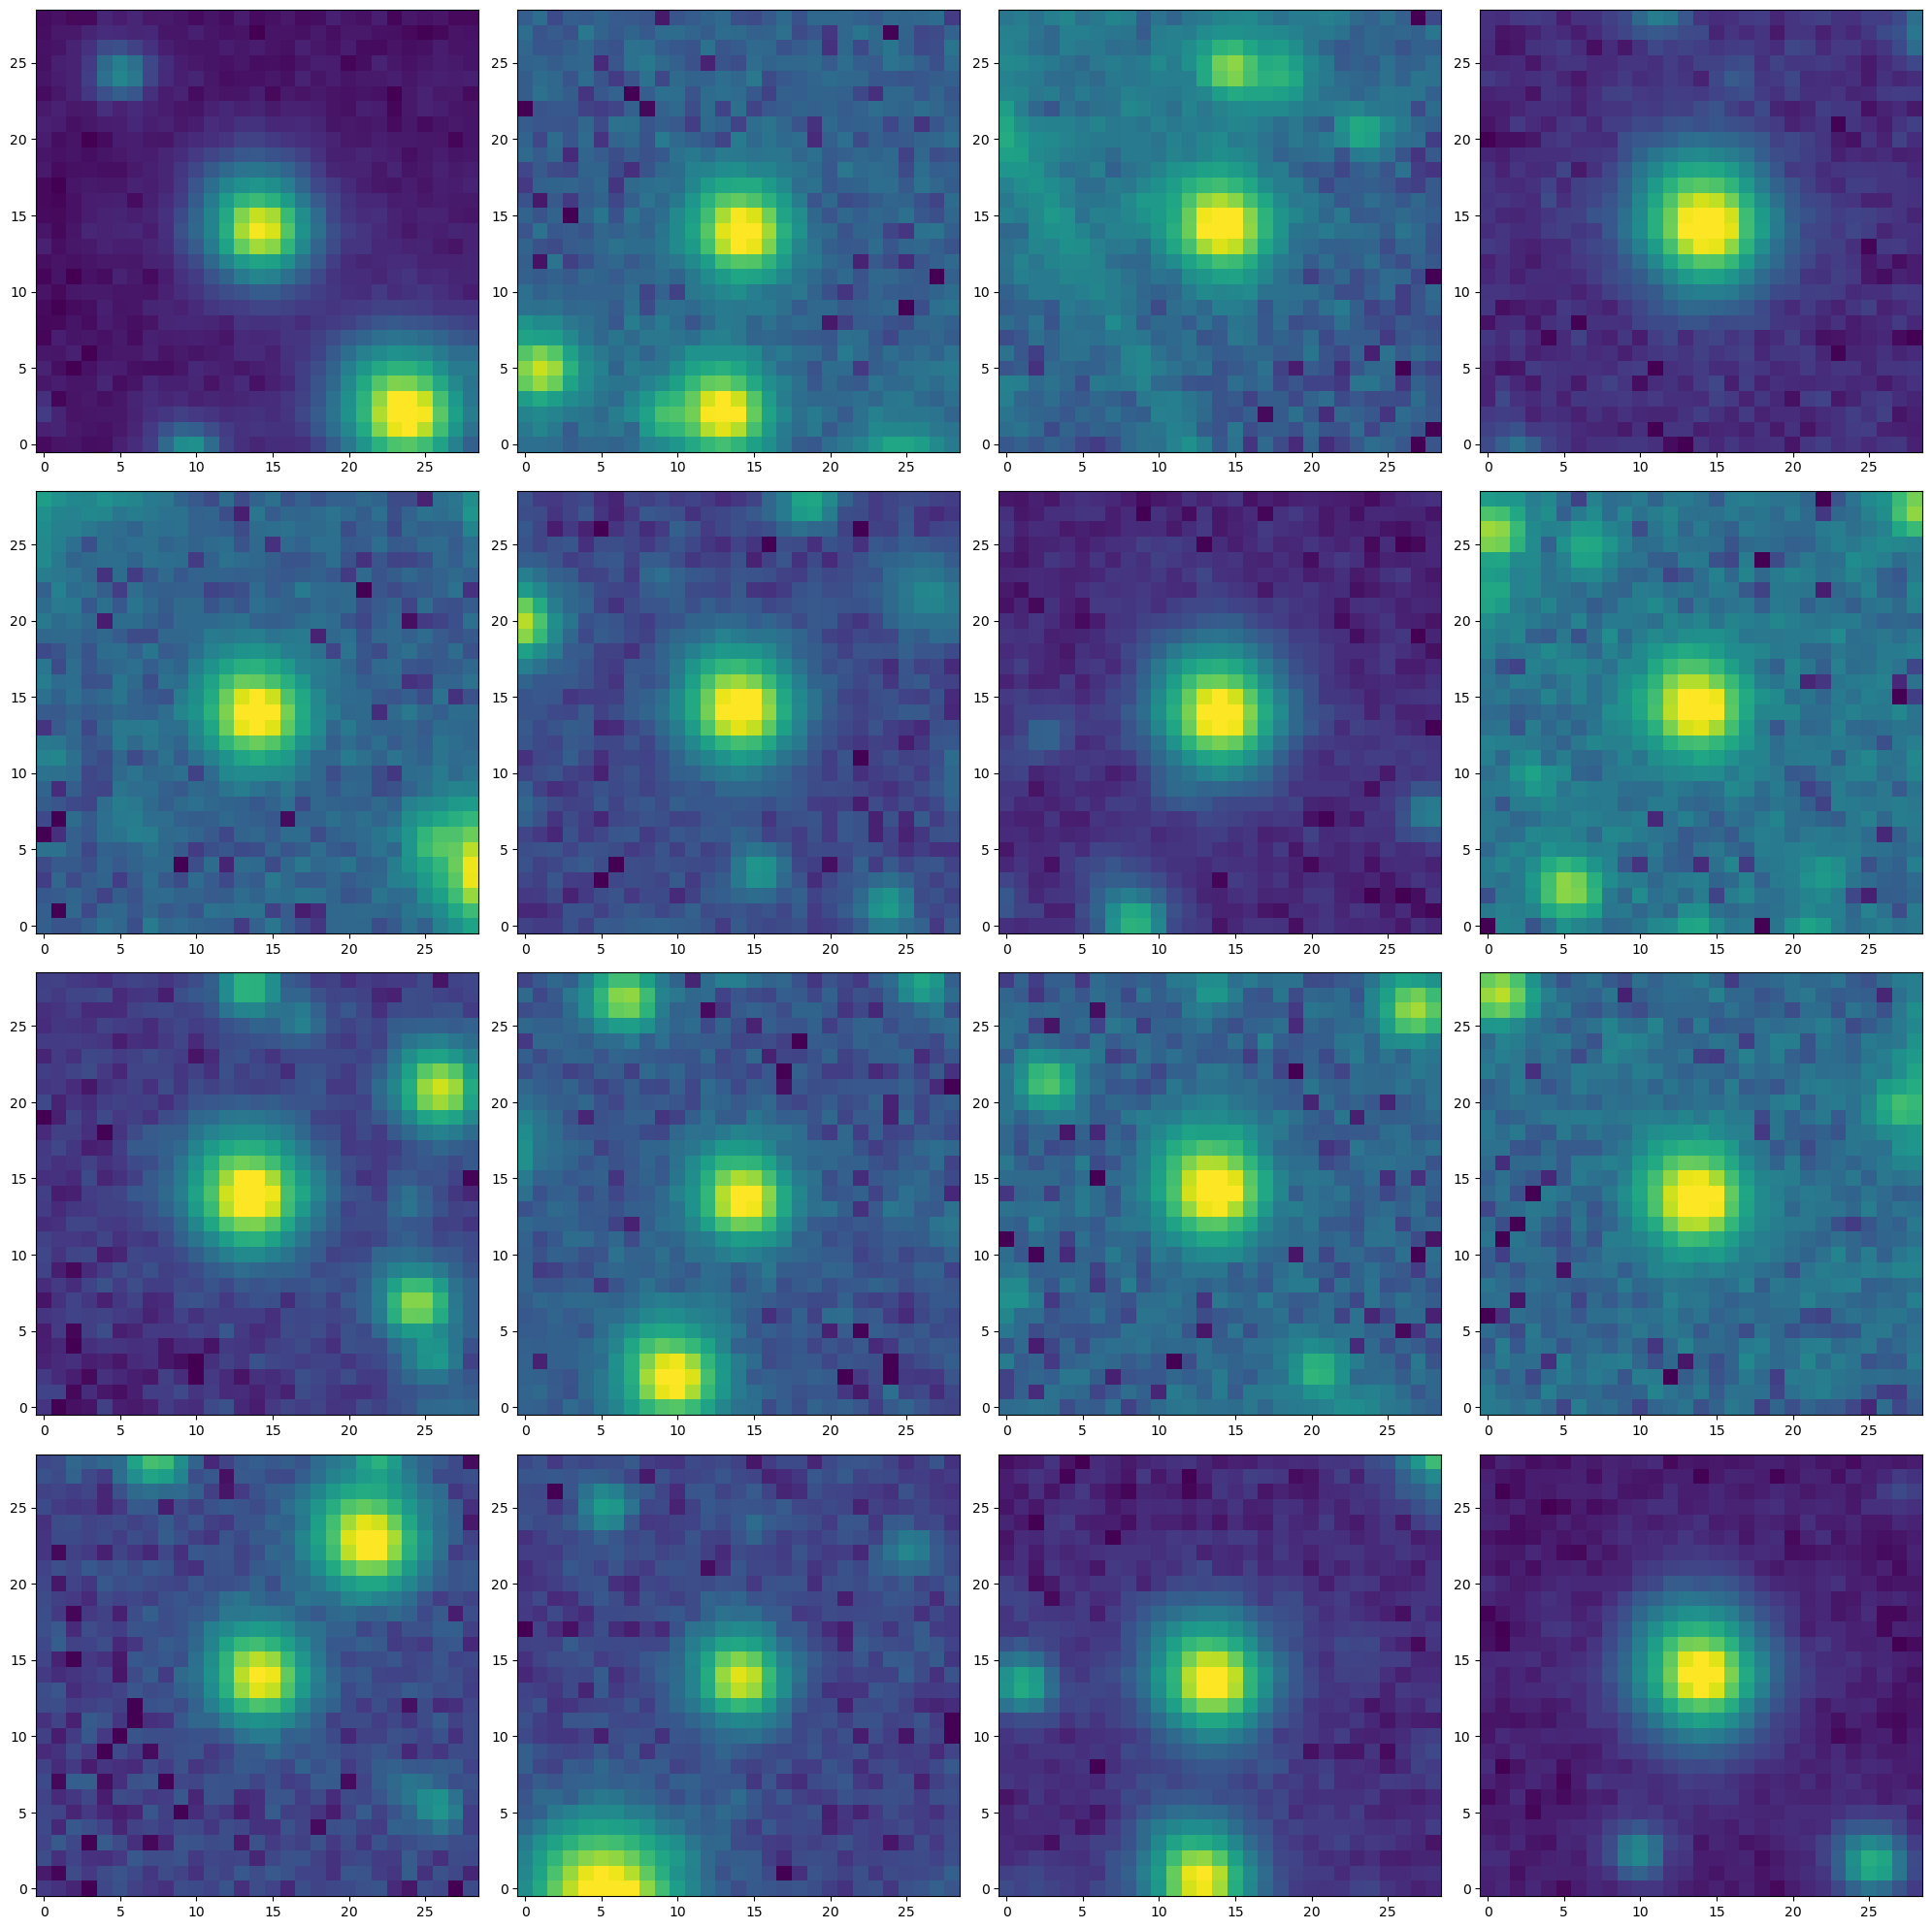

In [17]:
from astropy.visualization import simple_norm
norm = simple_norm(self.epsf.data, 'log', percent=99.0)
plt.imshow(self.epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.show()

fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for i, ax in enumerate(axes.flatten()):
    norm = simple_norm(self.stars.all_good_stars[i], 'log', percent=99.0)
    ax.imshow(self.stars.all_good_stars[i], norm=norm, origin='lower', cmap='viridis')
    width = self.stars.all_good_stars[i].shape[1]
plt.tight_layout()
plt.show()

In [ ]:
import os
import dill as pickle
import ztffields
import numpy as np
import matplotlib.pyplot as plt

from concurrent.futures import ProcessPoolExecutor, as_completed
from astropy.io import fits, ascii

try:
    from Tile import Tile
    from utils import get_data_path
except ModuleNotFoundError:
    from Extracting.Tile import Tile
    from Extracting.utils import get_data_path

In [ ]:
# Load the field geometries
fields = ztffields.Fields()  # TODO: Some filter on fields
field_info, field_polygons = fields.get_field_vertices([1557, 1558], level='quadrant', steps=2)

In [ ]:
data_path = get_data_path()
quadrant = field_polygons[0][0]

# Get the center of the quadrant
ra_center, dec_center = np.mean(quadrant[:, 0]), np.mean(quadrant[:, 1])

# Make a tile, run extraction, and store the catalogs
tile = Tile(
    ra_center,
    dec_center,
    bands=['i'],
    data_dir=os.path.join(data_path, 'ztf_data'),
    parallel=False
)

Querying metadata from https://irsa.ipac.caltech.edu/ibe/search/ztf/products/deep?WHERE=ra>89.80769428070157+AND+ra<90.69658318070158+AND+dec>12.446347031680897+AND+dec<13.335235931680899+AND+filtercode='zi'
Image already downloaded and saved at /Users/adamboesky/Research/long_transients/Data/ztf_data/ztf_000512_zi_c12_q1_refimg.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Extracting sources...
Calculating Kron magnitudes...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point
/Users/adamboesky/Research/long_transients/Extracting/utils.py:36: RuntimeWarning: overflow encountered in power
  flux = 10 ** ((mag - zero_point) / -2.5)


Calculating PSF magnitudes...
Fitting PSF model using 3935 stars...


/Users/adamboesky/Research/long_transients/Extracting/utils.py:27: RuntimeWarning: invalid value encountered in log10
  mag = -2.5 * np.log10(flux) + zero_point


OSError: File /Users/adamboesky/Research/long_transients/Data/local_catalog_results/000512_12_1/PSTARR.ecsv already exists. If you mean to replace it then use the argument "overwrite=True".

In [13]:
residual_image = tile.ztf_catalogs['i'].sextractors['i'].psfphot.make_residual_image(tile.ztf_catalogs['i'].sextractors['i'].image_sub, (9, 9))

# Create a new FITS file with the residual image data
hdu = fits.PrimaryHDU(residual_image)
hdul = fits.HDUList([hdu])

# Save the FITS file
output_path = 'residual_image.fits'
hdul.writeto(output_path, overwrite=True)

In [14]:
# Create a new FITS file with the residual image data
hdu = fits.PrimaryHDU(tile.ztf_catalogs['i'].sextractors['i'].image_sub)
hdul = fits.HDUList([hdu])

# Save the FITS file
output_path = 'original_image.fits'
hdul.writeto(output_path, overwrite=True)

In [36]:
tab = ascii.read('/Users/adamboesky/Research/long_transients/Data/local_catalog_results/000512_12_1/i_associated.ecsv')

(10.0, 27.0)

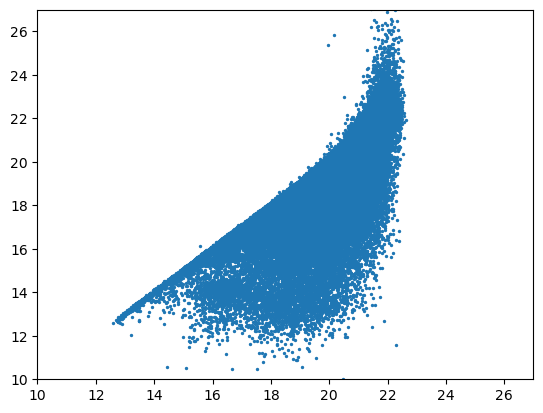

In [40]:
plt.scatter(tab['ZTF_iPSFMag'], tab['ZTF_iKronMag'], s=2)
plt.xlim((10, 27))
plt.ylim((10, 27))

(10.0, 27.0)

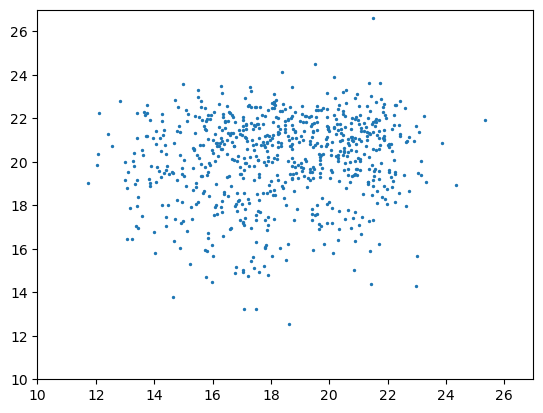

In [42]:
plt.scatter(tab['ZTF_iKronMag'], tab['PSTARR_iKronMag'], s=2)
plt.xlim((10, 27))
plt.ylim((10, 27))